In [98]:
#import required packages
import nltk
import pandas as pd
import csv
import re
import numpy as np
import os
import gensim
import glob
import spacy
import random
import matplotlib.pyplot
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk import ngrams
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis


In [99]:
#Open sample cases
#Generate file names using glob
filenames = [I for I in glob.glob('data/sample_dataset_2/*.txt')]

#Save them as one massive list
list_cases = list()

for file in filenames:
    case = open(r"" + file + "", "r")
    case = case.read()
    list_cases.append(case)


In [100]:

#Default stopwords list
from nltk.corpus import stopwords
stopwords_def = stopwords.words('english')

#Keep only real words
from nltk.corpus import words
from nltk.corpus import wordnet

#Define words as anything distinct in these two NLTK sets
real_word_set = set(words.words() + list(wordnet.words()))
    
#Depluralize all nouns
import pattern
from pattern.en import singularize

#Find words that end with 's' that need to be handled differently than plurals
exceptions = pd.read_csv('./preprocessing/singularized_exceptions.csv')
exceptions_list = exceptions.to_dict('records')
exceptions_list = exceptions_list[0]

#Set a function to process these words differently
def singularize_esp(word):
    if word in exceptions_list:
        return exceptions_list.get(word)
    return singularize(word)
    
#Want to keep certain words capitalized
proper_nouns = pd.read_csv('./preprocessing/proper_nouns.csv', header = None)
proper_nouns = proper_nouns.values.tolist()
proper_nouns = proper_nouns[0]

def recapitalize(word):
    if word in proper_nouns:
        return word
    if word.lower() in real_word_set:
        return word.lower()   
    else:
        return word
    
#n-gram helper function
def replace_ngram(text, bigrams, trigrams):
    
    for gram in trigrams:
        pattern = r'\b' + r'\s+'.join(gram.split()) + r'\b'
        replacement = '_'.join(gram.split())
        text = re.sub(pattern, replacement, text)
    
    for gram in bigrams:
        pattern = r'\b' + r'\s+'.join(gram.split()) + r'\b'
        replacement = '_'.join(gram.split())
        text = re.sub(pattern, replacement, text)
    
    return text

#Lemmatize based on part of speech (pos tagging)

def pos_lemmatize(word, tag):
    if tag.startswith('J'):
        return lemmatizer.lemmatize(word, pos='a')  # Adjective
    elif tag.startswith('V'):
        return lemmatizer.lemmatize(word, pos='v')  # Verb
    elif tag.startswith('N'):
        return lemmatizer.lemmatize(word, pos='n')  # Noun
    elif tag.startswith('R'):
        return lemmatizer.lemmatize(word, pos='r')  # Adverb
    else:
        return lemmatizer.lemmatize(word)  # Default to noun

#Get rid of proper nouns
name_remove = spacy.load("en_core_web_sm")
def remove_proper_nouns(text):
    doc = name_remove(text)
    filtered_text = " ".join([token.text for token in doc if token.pos_ != "PROPN"])
    return filtered_text

#Filter to keep only nouns
def nouns(word):
    pos_word = nltk.pos_tag(word)
    filtered = [word[0] for word in pos_word if word[1] in ['NN', 'NNP', 'NNS', 'NNPS']]
    return filtered    

In [101]:
lemmatized_documents = []
for doc in list_cases:
    draft_case = doc
    #Use regex to do a preliminary cleaning of the content
    ### Remove punctuation and numbers
    draft_case = re.sub("[0-9]", "", draft_case) #Removes numbers
    draft_case = re.sub(r"\/", " ", draft_case) #Replaces slashes with spaces
    draft_case = re.sub(r"\'", " ", draft_case) #Replaces apostrophes with spaces
    draft_case = re.sub(r"\-", " ", draft_case) #Replaces en-dash with spaces
    draft_case = re.sub(r"\–", " ", draft_case) #Replaces em-dash with spaces
    draft_case = re.sub(r"[.,?!()•$;:@§%&~\[\]\"]", "", draft_case) #Removes extraneous punctuation
    draft_case = re.sub(r"^$n','\n", "", draft_case, re.MULTILINE) #Removes empty lines
    draft_case = re.sub(r"\b\w{1,2}\b", '', draft_case) #Removes all one and two-character words (none have meaning)
    draft_case = re.sub(r"\n","", draft_case) #Removes extraneous line breaks


    #Remove extraneous information about lawyers and case detail that doesn't impact the content of the case
    starting_phrase = "PRELIMINARY STATEMENT" #Use this as the starter for when the actual lawsuit begins
    remove_before = r'^.*?{}'.format(re.escape(starting_phrase))
    draft_case = re.sub(remove_before, "", draft_case, flags=re.DOTALL)

    #Remove "FIRST AMENDED COMPLAINT", which is at the bottom of every page
    draft_case = re.sub(r"FIRST AMENDED COMPLAINT", "", draft_case)

    #These steps are done last since other words' removal will impact them
    draft_case = re.sub(r"\s+", " ", draft_case) #Removes multiple whitespaces
    draft_case = re.sub(r"([a-z])([A-Z])", r"\1 \2", draft_case) #Separates words that were joined together by double spaces

    #Word tokenization
    draft_case = word_tokenize(draft_case)


    #Singularize
    draft_case = [singularize_esp(word) for word in draft_case]

    #Recapitalize proper nouns only
    draft_case = [recapitalize(word) for word in draft_case]

    #Remove stopwords
    #Remove all non-real words (done twice since wordnet "real words" set includes names)
    draft_case = [word for word in draft_case if ((word not in stopwords_def) and (word in real_word_set or word in proper_nouns))]
    draft_case = [remove_proper_nouns(word) for word in draft_case]

    #After removing non-real words, implement n-grams

    ##Return draft_case into a string
    draft_case = ' '.join(draft_case)
    ##Create n-grams using pointwise mutual information

    ###Create bigrams and use PMI to score them
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = nltk.collocations.BigramCollocationFinder.from_words(str.split(draft_case))
    ####Apply a frequency filter
    finder.apply_freq_filter(10)
    bigram_scores = finder.score_ngrams(bigram_measures.pmi)

    ###Do the same for trigrams
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    finder = nltk.collocations.TrigramCollocationFinder.from_words(str.split(draft_case))
    ####Frequency filter
    finder.apply_freq_filter(10)
    trigram_scores = finder.score_ngrams(trigram_measures.pmi)

    #Store the scores as dataframes
    bigram_pmi = pd.DataFrame(bigram_scores)
    bigram_pmi.columns = ['bigram', 'pmi']
    bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
    #Save only the bigrams with PMI greater than 5 (arbitrary threshold)
    bigram_pmi = bigram_pmi[bigram_pmi.apply(lambda bigram: bigram.pmi > 5, axis = 1)][:500]

    trigram_pmi = pd.DataFrame(trigram_scores)
    trigram_pmi.columns = ['trigram', 'pmi']
    trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
    #Save only the trigrams with PMI greater than 5 (arbitrary threshold)
    trigram_pmi = trigram_pmi[trigram_pmi.apply(lambda trigram: trigram.pmi > 5, axis = 1)][:500]

    #Keep only the values
    bigrams = [' '.join(x) for x in bigram_pmi.bigram.values]
    trigrams = [' '.join(x) for x in trigram_pmi.trigram.values]

    # Concatenate n-grams
    draft_case = replace_ngram(draft_case, bigrams, trigrams)

    #Lemmatization
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()

    #Re-tokenize
    draft_case = word_tokenize(draft_case)

    #Tag by part of speech
    from nltk import pos_tag
    tagged_word_content = pos_tag(draft_case)

    #Need to lemmatize using part of speech to ensure accuracy
    # Lemmatize using part of speech
    lemmatized_output = [pos_lemmatize(word, tag) for word, tag in tagged_word_content]
    lemmatized_output = nouns(lemmatized_output)
    
    print(lemmatized_output[0:100])

    lemmatized_documents.append(lemmatized_output)


['mc', 'office', 'counsel', 'municipal_utility_district', 'eleventh', 'clerk', 'county', 'fax', 'filing', 'code', 'coffin', 'montgomery', 'San', 'Francisco', 'telephone', 'fax', 'coffin', 'dd', 'attorney', 'petitioner', 'municipal_utility_district', 'superior_court', 'state', 'californium', 'county', 'case', 'petitioner', 'notice', 'californium', 'county', 'action', 'county_board_supervisor', 'quality', 'act', 'pub', 'resource_code', 'respondent', 'land', 'land', 'land', 'party', 'interest', 'notice', 'californium', 'attorney', 'commencement', 'action', 'Costa', 'superior_court_case', 'attorney', 'state', 'californium', 'please', 'resource_code', 'municipal_utility_district', 'district', 'petition_writ_mandate', 'respondent', 'Costa_county', 'Costa', 'county_board_supervisor', 'Costa_county', 'superior_court', 'challenge', 'action', 'park', 'project', 'project', 'unit', 'family', 'housing', 'development', 'Costa_county', 'supply', 'water', 'connection', 'approval', 'respondent', 'repor

In [ ]:
#Remove the legal corpus
adtl_stopwords = pd.read_csv("./preprocessing/final_legal_corpus_supplemented.csv")

adtl_stopwords = adtl_stopwords[['Word']]
adtl_stopwords = adtl_stopwords.values.tolist()
adtl_stopwords = [word for sublist in adtl_stopwords for word in sublist]

print(adtl_stopwords)
print("county" in adtl_stopwords)
print(lemmatized_documents[1])

lemmatized_documents = [[word for word in doc if word.lower() not in adtl_stopwords] for doc in lemmatized_documents]

print(len(lemmatized_documents))
print(lemmatized_documents[0])
print(lemmatized_documents[1])
print(lemmatized_documents[2])
print(lemmatized_documents[3])
print(lemmatized_documents[5])
print(lemmatized_documents[6])
print(lemmatized_documents[7])
print(lemmatized_documents[8])
print(lemmatized_documents[9])


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]
False
['terry', 'mc', 'San', 'Lui', 'deputy', 'telephone', 'club', 'californium', 'club', 'b', 'cv', 'bakersfield', 'petition_peremptory_writ', 'corporation', 'mandate_complaint', 'pub', 'engineering', 'rex', 'introduction', 'club', 'Bakersfield', 'Bakersfield', 'city_council', 'amendment', 'zone', 'certification', 'study', 'prepare', 'seek', 'reconsider', 'quality', 'club', 'profit', 'membership', 'concern', 'protection', 'club', 'reside', 'Bakersfield', 'vicinity', 'club', 'Bakersfield', 'subdivision', 'charge', 'authority', 'administer', 'land', 'territory', 'compliance', 'duly', 'provision', 'zone', 'ordinance', 'provision', 'quality', 'subdivision', 'map', 'defendant', 'city_council', 'Bakersfield', 'city_counc

In [93]:
#Implement tf-idf weights for additional pruning

from sklearn.feature_extraction.text import TfidfVectorizer

lemmatized_documents_joined = [' '.join(doc) for doc in lemmatized_documents]

# Create a TfidfVectorizer object

tfidf_vectorizer = TfidfVectorizer(tokenizer=None, preprocessor=None)

# Fit and transform the documents
tfidf_matrix = tfidf_vectorizer.fit_transform(lemmatized_documents_joined)

# Get the feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

print(tfidf_df)


   abdicate   ability   absence    absent  absolute   abstain     abuse  \
0  0.000000  0.022297  0.001980  0.004459  0.000000  0.004459  0.004348   
1  0.000000  0.000000  0.007827  0.000000  0.000000  0.000000  0.034380   
2  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3  0.000000  0.000000  0.009676  0.000000  0.000000  0.000000  0.000000   
4  0.000000  0.000000  0.007887  0.000000  0.000000  0.000000  0.017321   
5  0.019474  0.000000  0.008645  0.000000  0.016555  0.000000  0.018986   
6  0.000000  0.000000  0.008646  0.000000  0.000000  0.000000  0.018989   
7  0.000000  0.000000  0.014555  0.000000  0.000000  0.000000  0.000000   
8  0.000000  0.000000  0.007022  0.000000  0.006724  0.000000  0.003856   
9  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.009648   

   abuse_discretion  abused_discretion  acceleration  ...  \
0          0.000000           0.000000      0.004459  ...   
1          0.000000           0.000000      0.000000

In [88]:
dictionary = corpora.Dictionary(lemmatized_documents)

doc_term_matrix = [dictionary.doc2bow(case) for case in lemmatized_documents]

In [73]:
coherence_list = []
for k in range(5,25):
    print('Topic number: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=40,\
                   iterations=200, chunksize = 10000, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=lemmatized_documents,\
                                                     dictionary=dictionary, coherence='c_v')
    coherence_list.append((k,cm.get_coherence()))

Topic number: 5
Topic number: 6


KeyboardInterrupt: 

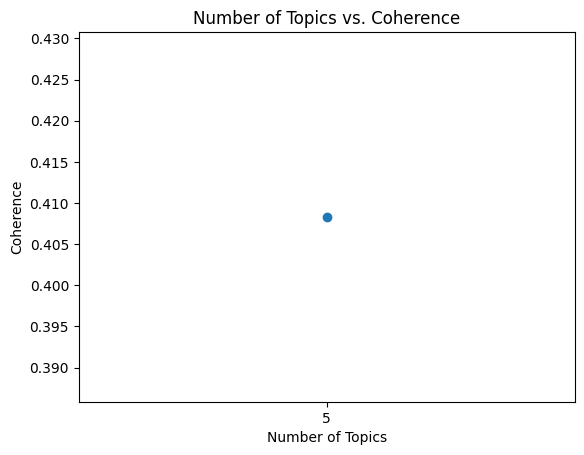

In [74]:
x_val = [x[0] for x in coherence_list]
y_val = [x[1] for x in coherence_list]
matplotlib.pyplot.plot(x_val,y_val)
matplotlib.pyplot.scatter(x_val,y_val)
matplotlib.pyplot.title('Number of Topics vs. Coherence')
matplotlib.pyplot.xlabel('Number of Topics')
matplotlib.pyplot.ylabel('Coherence')
matplotlib.pyplot.xticks(x_val)
matplotlib.pyplot.show()

In [89]:
""" from gensim.utils import simple_preprocess """

""" dict_singlefile = corpora.Dictionary(simple_preprocess(line, deacc =True) for line in lemmatized_output)
print("The dictionary has: " +str(len(dict_singlefile)) + " tokens")
doc_term_matrix = [dict_singlefile.doc2bow(text.lower().split()) for text in lemmatized_output] """ 

lda_model = gensim.models.LdaMulticore(corpus=doc_term_matrix,
                            id2word=dictionary,
                            num_topics=27,  # Adjust the number of topics as needed
                            random_state=100,
                            per_word_topics=True)

for idx, topic in lda_model.print_topics(num_topics = 27, num_words = 15):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.012*"water" + 0.012*"district" + 0.011*"planning_commission" + 0.007*"structure" + 0.007*"unit" + 0.006*"city_council" + 0.006*"cottage" + 0.006*"expansion" + 0.005*"exemption" + 0.005*"facility" + 0.005*"land" + 0.005*"staff" + 0.005*"parcel" + 0.005*"record" + 0.004*"year"
Topic: 1 
Words: 0.020*"district" + 0.015*"water" + 0.007*"exemption" + 0.006*"record" + 0.006*"board" + 0.006*"cup" + 0.006*"permit" + 0.006*"year" + 0.006*"land" + 0.005*"school" + 0.005*"facility" + 0.005*"quality" + 0.005*"supply" + 0.005*"structure" + 0.005*"policy"
Topic: 2 
Words: 0.025*"district" + 0.008*"tolling_agreement" + 0.007*"water" + 0.006*"exemption" + 0.005*"resort" + 0.004*"quality" + 0.004*"land" + 0.004*"San" + 0.004*"facility" + 0.004*"agreement" + 0.004*"record" + 0.004*"structure" + 0.004*"biological_assessment" + 0.004*"policy" + 0.004*"board"
Topic: 3 
Words: 0.045*"district" + 0.030*"water" + 0.012*"supply" + 0.009*"policy" + 0.008*"board" + 0.007*"year" + 0.007*"annexa

In [90]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)
pyLDAvis.display(vis)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/Library/Frameworks/Python.framework/Ve

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
pd.set_option("display.max_rows", 600)
from pathlib import Path  
import glob